In [14]:
import casadi
import numpy as np
from utils.collocation import *
import pinocchio as pin
from pinocchio import casadi as cpin
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import scipy

In [15]:
Ntp = 10  # Number of collocation points / basis (degree: Ntp-1)

In [16]:
ngc = 5
nhc = 3
ndof = ngc-nhc

Lbase = 0.12
Ldistal = 0.15
Lproximal = 0.2
mdistal = 0.8925
mproximal = 1.2093

Loffset = np.array([0, Lproximal, Ldistal, Ldistal, Lproximal])

mass = np.array([mproximal, mdistal, mdistal, mproximal])
Lcm = np.array([0.11, 0.0746, Ldistal-0.0746, Lproximal-0.11])
Iz = np.array([7, 2.3, 2.3, 7])*1e-3

inertia = [None]*ngc
for i in range(ngc-1):
    inertia[i] = pin.Inertia(mass[i], np.array([Lcm[i], 0.0, 0.0]), np.diag([0, Iz[i], Iz[i]])) # mass, com, inertia


FourBar = pin.Model()
joint_id = 0  # Root

for i in range(ngc):
    joint_type = pin.JointModelRY()    # Define joint type (Revolute joint around Y-axis)
    
    # Add joint to the model ->    joint_index = model.addJoint(parent_frame, joint_type, child_frame, joint name)
    joint_id = FourBar.addJoint(joint_id, joint_type, pin.SE3(np.eye(3), np.array([Loffset[i],0,0])), f'joint {i+1}')
    
    # Append body to the joint ->  body_id = model.appendBodyToJoint(joint_id, inertia, joint_placement)
    if i < ngc-1:
        body_id = FourBar.appendBodyToJoint(joint_id, inertia[i], pin.SE3.Identity())

data = FourBar.createData()

In [17]:
q = casadi.SX.sym("q", ngc, 1)
dq = casadi.SX.sym("dq", ngc, 1)

# kinematic loop
q1_ = q[0]
q2_ = q1_+q[1]
q3_ = q2_+q[2]
q4_ = q3_+q[3]
q5_ = q4_+q[4]

F_q = [ Lproximal*np.cos(q1_) + Ldistal*np.cos(q2_) + Ldistal*np.cos(q3_) + Lproximal*np.cos(q4_) + Lbase,
        Lproximal*np.sin(q1_) + Ldistal*np.sin(q2_) + Ldistal*np.sin(q3_) + Lproximal*np.sin(q4_),
        np.sin(q5_) ]
Fq = casadi.vertcat(*F_q)  # Fq(q=np.array([1,0,0]))  -> 'SX' object is not callable
Jq = casadi.jacobian(Fq, q)
dJq_dt = casadi.jtimes(Jq, q, dq)   # (nhc, ngc)
F_holonomic = casadi.Function("F_holonomic", [q], [Fq])
J_holonomic = casadi.Function("J_holonomic", [q], [Jq])

# acceleration constraint   -> nhc
#x_holonomic = casadi.Function("x_holonomic", [q,dq], [-dJq_dt @ dq])  
# J(q) @ ddq = x(q,dq) = -dJ(q)/dt @ dq    -> nhc

In [18]:
# open-chain dynamics
cmodel = cpin.Model(FourBar)
cdata = cmodel.createData()

# Mass matrix
M = cpin.crba(cmodel, cdata, q)
# Coriolis
C = cpin.computeCoriolisMatrix(cmodel, cdata, q, dq)
# Gravity
G = cpin.computeGeneralizedGravity(cmodel, cdata, q)

ConstrDyn = casadi.vertcat(casadi.horzcat(M, Jq.T), casadi.horzcat(Jq, casadi.DM.zeros(nhc, nhc)))

u = casadi.SX.sym("u", ndof, 1)             # control input
uc = casadi.vertcat(*[u[0],0,0,0,u[-1]])    # number of active joints = ndof
#u = casadi.SX.sym("u", ngc, 1)
Tau = uc - C @ dq - G  

un = casadi.SX.sym("un", ngc, 1)
F_Acc = casadi.Function(
    "F_Acc",
    [q, dq, un],
    [casadi.vertcat(dq,
                    cpin.aba(cmodel, cdata, q, dq, un))]
)

F_ConstrAcc = casadi.Function(
    "ConstrAcc", 
    [q, dq, u], 
    [
        casadi.vertcat(dq, 
                       casadi.horzcat(np.eye(ngc), np.zeros((ngc, nhc))) @ casadi.inv(ConstrDyn) @ casadi.vertcat(Tau, -dJq_dt@dq))
    ]
)

print(F_ConstrAcc)
# Facc  -> (2*ngc, )

ConstrAcc:(i0[5],i1[5],i2[2])->(o0[10]) SXFunction


### Local Parameterization (Tangent Chart)

In [19]:
def local_basis(q0):
    J0 = J_holonomic(q0)
    nhc, ngc = J0.shape
    Q , _ = casadi.qr(J0.T)  # column of Q -> row space of J0 / normal space of manifold
    
    # null space of J0 -> tangent space of manifold
    I = casadi.DM.eye(ngc)
    k = 0
    basis = Q
    for i in range(ngc):
        vertI = I[:,i] - basis @ basis.T @ I[:,i]
        if casadi.norm_2(vertI) >= 10e-3:
            basis = casadi.horzcat(basis, vertI / casadi.norm_2(vertI))
            k += 1
        if k == ngc - nhc:
            break
    return basis  #[normal, tangent] = [u, v]

# Constrained manifold to local coordinates
q0 = casadi.SX.sym("q0", ngc, 1)
q0_basis = casadi.SX.sym("q0_basis", ngc, ngc)

Vbasis = q0_basis[:,nhc:]  # tangent space
Ubasis = q0_basis[:,:nhc]  # normal space

q_manifold_to_local = casadi.Function("Phi", [q, q0, q0_basis], [Vbasis.T @ (q-q0)])  # ngc -> ndof
dq_manifold_to_local = casadi.Function("dPhi", [dq, q0_basis], [Vbasis.T @ dq])       # ngc -> ndof

# Local coordinates to constrained manifold
q_lc = casadi.SX.sym("q_lc", ndof, 1)
dq_lc = casadi.SX.sym("dq_lc", ndof, 1)
ddq_lc = casadi.SX.sym("dq_lc", ndof, 1)

opts = {'abstol':1e-10,
        'max_iter':1000}
h = casadi.SX.sym("h", nhc, 1)

def q_local_to_manifold(q0, q0_basis, v):  # q = q0 + V_basis @ v - U_basis @ h(v)          # ndof -> ngc
    Feq = casadi.Function("Feq", [h], [F_holonomic(q0 + q0_basis[:,nhc:] @ v + q0_basis[:,:nhc] @ h)])
    h_v = casadi.rootfinder('Phi', 'newton', Feq, opts)
    return np.squeeze(q0 + q0_basis[:,nhc:] @ v + q0_basis[:,:nhc] @ h_v(np.zeros(nhc)))

Bq = casadi.inv(J_holonomic(q) @ Ubasis)
Dq = Vbasis - Ubasis @ Bq @ J_holonomic(q) @ Vbasis

dq_local_to_manifold = casadi.Function(                                                         # ndof -> ngc
    "dPhi_inv", 
    [dq_lc, q, q0_basis], 
    [Dq @ dq_lc])

ddq_local_to_manifold = casadi.Function(                                                        # ndof -> ngc
    "ddPhi_inv",
    [dq_lc, ddq_lc, q, dq, q0_basis],
    [Dq @ ddq_lc + casadi.jtimes(Dq, q, dq)@dq_lc]#- Ubasis @ Bq @ casadi.jtimes(J_holonomic(q), q, Dq@dq) @ dq_lc]
)


J_Local = casadi.Function(     # 2ndof * 2ngc
    "J_Local", 
    [q0_basis], 
    [
        casadi.vertcat(casadi.horzcat(Vbasis.T, casadi.DM.zeros(ndof, ngc)),
                       casadi.horzcat(casadi.DM.zeros(ndof, ngc), Vbasis.T))
    ]
)
print(J_Local)

# Dynamics of local coordinates      
F_LocalAcc = casadi.Function(  # -> 2ndof
    "ConstrAcc", 
    [q, dq, u, q0_basis], 
    [
        J_Local(q0_basis) @ F_ConstrAcc(q, dq, u)  # dy = dPhi/dx * dx = J_Local * F(x)
]
)
print(F_LocalAcc)


dt = casadi.SX.sym("dt")
F_LocalIntegrate = casadi.Function(    # One-step Euler integration
    "xIntegrate", 
    [q, dq, q_lc, dq_lc, u, q0_basis, dt], 
    [
        casadi.vertcat(q_lc + dq_lc * dt, 
                       dq_lc + F_LocalAcc(q, dq, u, q0_basis)[ndof:] * dt)
    ]
)
print(F_LocalIntegrate)


t = casadi.SX.sym("t")
u_collo_pts = casadi.SX.sym("collo_pts", Ntp, 1)
u_collo_vars = [casadi.SX.sym("collo_vars", ndof, 1) for _ in range(Ntp)]

t1 = casadi.SX.sym("t_start")
t2 = casadi.SX.sym("t_end")

def RK4(f, q, dq, inter_u, t1, t2, u_collo_pts, u_collo_vars):
    dt = t2 - t1
    k1 = f(q, dq, inter_u(t1, u_collo_pts, u_collo_vars))
    k2 = f(q+ dt/2* k1[:ngc], dq+ dt/2* k1[ngc:], inter_u(t1+dt/2, u_collo_pts, u_collo_vars))
    k3 = f(q+ dt/2* k2[:ngc], dq+ dt/2* k2[ngc:], inter_u(t1+dt/2, u_collo_pts, u_collo_vars))
    k4 = f(q+ dt* k3[:ngc], dq+ dt* k3[ngc:], inter_u(t2, u_collo_pts, u_collo_vars))
    return casadi.vertcat(q,dq) + dt/6 * (k1 + 2*k2 + 2*k3 + k4)


inter_u = casadi.Function(
    "ut", 
    [t, u_collo_pts, casadi.vertcat(*u_collo_vars)], [LagrangeInterpolation(t, u_collo_pts, u_collo_vars)]
)

F_Integrate = casadi.Function(
    "qIntegrate", 
    [q, dq, t1, t2, u_collo_pts, casadi.vertcat(*u_collo_vars)], 
    [
        RK4(F_ConstrAcc, q, dq, inter_u, t1, t2, u_collo_pts, casadi.vertcat(*u_collo_vars))
    ]
)
print(F_Integrate)

J_Local:(i0[5x5])->(o0[4x10]) SXFunction
ConstrAcc:(i0[5],i1[5],i2[2],i3[5x5])->(o0[4]) SXFunction
xIntegrate:(i0[5],i1[5],i2[2],i3[2],i4[2],i5[5x5],i6)->(o0[4]) SXFunction
qIntegrate:(i0[5],i1[5],i2,i3,i4[10],i5[20])->(o0[10]) SXFunction


In [20]:
Np = 1       # Number of phase (dersired waypoints: N+1)
T = Np*Ntp   # Number of total collocation points / optimization variables

#LGL_Pts = np.linspace(-1, 1, Ntp)
LGL_Pts, LGL_Wts = Normalize_LGL_Pts_Wts(Ntp) # LGL points
DL, _ = differentiation_matrix(Ntp, LGL_Pts)  # Differentiation matrices

In [21]:
deltaT = casadi.SX.sym("t")                                        # Time interval
Coffs = casadi.SX.sym('Coff', Ntp)
def VarDiff(Coeffs, Var):
    Res = casadi.SX(0)
    for i in range(len(Var)):
        Res += Coeffs[i] * Var[i]
    return Res

cy_list = [casadi.SX.sym(f'y{i}', 2*ndof, 1) for i in range(Ntp)]  # local coordinates
LocalsDiff = casadi.Function(
    "Ydot",
    [casadi.vertcat(*cy_list), deltaT, Coffs],
    [
        2*VarDiff(Coffs, cy_list)/deltaT,
    ],
)

cp_list = [casadi.SX.sym(f'p{i}', ndof, 1) for i in range(Ntp)]
LocalDiff = casadi.Function(
    "pdot",
    [casadi.vertcat(*cp_list), deltaT, Coffs],
    [
        2*VarDiff(Coffs, cp_list)/deltaT
    ]
)

In [22]:
lowerPositionLimit = -2*np.pi * np.ones((ngc))  # rad
upperPositionLimit = 2*np.pi * np.ones((ngc))   # rad
lowerVelocityLimit = -np.pi/2 * np.ones((ngc))  # rad/s
upperVelocityLimit = np.pi/2 * np.ones((ngc))
lowerTorqueLimit  = -5 * np.ones((ndof))
upperTorqueLimit  = 5 * np.ones((ndof))

q_waypoints = np.array([[1.3919,0.7860,1.9008,0.7278,1.4766], 
                        [2.0851,-0.6221,3.5712,-0.7617,2.0107]])
q0_ = q_waypoints[0]
qT_ = q_waypoints[-1]
q0_basis = local_basis(q0_)  # basis.T @ basis -> identity matrix 
print(F_holonomic(q0_))
print(F_holonomic(qT_))

y0_ = q_manifold_to_local(q0_, q0_, q0_basis)
yT_ = q_manifold_to_local(qT_, q0_, q0_basis)
print(yT_)


[-8.73841e-06, 1.14392e-05, -8.53072e-05]
[2.73737e-05, -2.98011e-06, 1.46928e-05]
[0.961803, -2.60921]


### Initial Guesses

In [23]:
t_initial = 2
#ini_pts = t_initial/2 * (LGL_Pts+1)
ini_collo_pts = t_initial/2 * (LGL_Pts+1)

ini_p = np.full((Ntp, ndof), 0.0)
ini_q = np.full((Ntp, ngc), 0.0)
for i in range(Ntp):
    ini_p[i,:] = np.squeeze(y0_ + ini_collo_pts[i]/t_initial*(yT_-y0_))
    ini_q[i,:] = q_local_to_manifold(q0_, q0_basis, ini_p[i,:])

In [24]:
ini_dp = np.array([np.squeeze(LocalDiff(casadi.vertcat(*ini_p), t_initial, DL[i,:])) for i in range(Ntp)])
ini_ddp = np.array([np.squeeze(LocalDiff(casadi.vertcat(*ini_dp), t_initial, DL[i,:])) for i in range(Ntp)])

ini_dq = np.array([np.squeeze(dq_local_to_manifold(ini_dp[i,:], ini_q[i,:], q0_basis)) for i in range(Ntp)])
ini_ddq = np.array([np.squeeze(ddq_local_to_manifold(ini_dp[i,:], ini_ddp[i,:], ini_q[i,:], ini_dq[i,:], q0_basis)) for i in range(Ntp)])
print(ini_ddq)

[[ 0.05603854 -0.01765277 -0.06702683 -0.02378158  0.05242264]
 [ 0.05288415 -0.0162918  -0.06301458 -0.02265136  0.04907359]
 [ 0.04677116 -0.01343998 -0.05509941 -0.02058273  0.04235095]
 [ 0.04006327 -0.00952851 -0.04590432 -0.01875661  0.03412617]
 [ 0.03519898 -0.00413416 -0.03756961 -0.01888398  0.02538877]
 [ 0.03552559  0.00618199 -0.03117095 -0.02493528  0.01439865]
 [ 0.05212476  0.0379433  -0.02692116 -0.05297117 -0.01017572]
 [ 0.14588963  0.18448953 -0.0243315  -0.19268834 -0.11335931]
 [ 0.68871095  1.02056512 -0.01735855 -0.99455192 -0.6973656 ]
 [ 2.2784625   3.49718198  0.02131929 -3.35885518 -2.43810859]]


In [25]:
ini_dyn = np.array([pin.rnea(FourBar, data, ini_q[i], ini_dq[i], ini_ddq[i]) for i in range(Ntp)])  # M@ddq + C@dq + G

# Lagrange multiplier of constraint force
multiplier = np.array([np.linalg.inv(J_holonomic(ini_q[i]).T[1:4,:]) @ -ini_dyn[i,1:4] for i in range(Ntp)])

ini_U = np.array([np.squeeze(ini_dyn[i] + J_holonomic(ini_q[i]).T @ multiplier[i]) for i in range(Ntp)])
print(ini_U)

ini_x = [None] * Ntp
ini_y = [None] * Ntp
ini_u = [None] * Ntp
for t in range(Ntp):
    ini_x[t] =  np.concatenate([ini_q[t],ini_dq[t]])
    ini_y[t] = np.concatenate([ini_p[t],ini_dp[t]])
    ini_u[t] = np.array([ini_U[t][0],ini_U[t][-1]])

[[-1.16032013e+00  0.00000000e+00  2.22044605e-16  3.88578059e-16
  -9.05335590e-01]
 [-1.04440998e+00 -1.33226763e-15 -8.88178420e-16 -3.05311332e-16
  -8.01382553e-01]
 [-7.85475126e-01  0.00000000e+00 -2.22044605e-16 -9.02056208e-17
  -5.70361025e-01]
 [-4.14173913e-01  0.00000000e+00 -4.44089210e-16 -3.05311332e-16
  -2.40496376e-01]
 [ 2.58172869e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.54331633e-01]
 [ 4.66959132e-01  0.00000000e+00  5.55111512e-17  8.32667268e-17
   5.91697007e-01]
 [ 3.74158021e+00 -5.10702591e-15 -6.52256027e-15 -4.99600361e-15
  -2.59523588e+00]
 [ 1.46294071e+00 -5.55111512e-17 -2.08166817e-16 -1.66533454e-16
   1.01483836e+00]
 [ 1.80642387e+00  1.11022302e-16  1.11022302e-16  1.66533454e-16
   1.09856764e+00]
 [ 2.20034349e+00  1.11022302e-16  2.22044605e-16  5.55111512e-17
   8.43201411e-01]]


### Nonlinear Optimization Problem (NLP)

In [26]:
opti = casadi.Opti()
# Optimization variables
var_xs = [opti.variable(2*ngc) for _ in range(T)]
var_ys = [opti.variable(2*ndof) for _ in range(T)]
var_us = [opti.variable(ndof) for _ in range(T)]
var_deltaT = [opti.variable(1) for _ in range(Np)]

for i in range(Np):
    opti.subject_to(var_deltaT[i] > 0.0)
    T_List = var_deltaT[i]/2 * (LGL_Pts+1)
    for tp in range(Ntp):
        t = i*Ntp + tp

        # constriants   solve x = H^(-1)(y) <-> y = H(x) and F(x) = 0
        opti.subject_to(F_holonomic(var_xs[t][:ngc]) == 0)
        opti.subject_to(q_manifold_to_local(var_xs[t][:ngc], q0_, q0_basis) == var_ys[t][:ndof])

        opti.subject_to(J_holonomic(var_xs[t][:ngc]) @ var_xs[t][ngc:] == 0)
        opti.subject_to(dq_manifold_to_local(var_xs[t][ngc:], q0_basis) == var_ys[t][ndof:])

        # Dynamics
        if tp < Ntp-1:
            opti.subject_to(var_ys[t+1] == 
                         F_LocalIntegrate(var_xs[t][:ngc], var_xs[t][ngc:], var_ys[t][:ndof], var_ys[t][ndof:], var_us[t], q0_basis, T_List[i+1]-T_List[i]))

        '''
        if tp < Ntp-1:
            x_next = F_Integrate(var_xs[t][:ngc], var_xs[t][ngc:], T_List[tp], T_List[tp+1],
                                        LGL_Pts, casadi.vertcat(*var_us[i*Ntp: (i+1)*Ntp]))
            
            opti.subject_to(q_manifold_to_local(var_xs[t+1][:ngc], q0_, q0_basis) == q_manifold_to_local(x_next[:ngc], q0_, q0_basis))
            opti.subject_to(dq_manifold_to_local(var_xs[t+1][ngc:], q0_basis) == dq_manifold_to_local(x_next[ngc:], q0_basis))
            opti.subject_to(F_holonomic(var_xs[t+1][:ngc]) == 0)
            opti.subject_to(J_holonomic(var_xs[t+1][:ngc]) @ var_xs[t+1][ngc:] == 0)
        '''
        
        # joint constraints
        opti.subject_to(var_xs[t][:ngc] <= upperPositionLimit)
        opti.subject_to(var_xs[t][:ngc] >= lowerPositionLimit)
        # joint velocity constraints
        opti.subject_to(var_xs[t][ngc:] <= upperVelocityLimit)
        opti.subject_to(var_xs[t][ngc:] >= lowerVelocityLimit)
        #torque constraints
        opti.subject_to(var_us[t] <= upperTorqueLimit)
        opti.subject_to(var_us[t] >= lowerTorqueLimit)

# boundary conditions
opti.subject_to(var_ys[0] == ini_y[0])
opti.subject_to(var_ys[-1] == ini_y[-1])
#opti.subject_to(var_xs[0] == ini_x[0])
#opti.subject_to(var_xs[-1] == ini_x[-1])


# Objective function
total_cost = 0
for i in range(Np):
    for tp in range(Ntp):
        total_cost += var_deltaT[i]/2 * LGL_Wts[tp] *var_us[i*Ntp+tp].T @ var_us[i*Ntp+tp]
    total_cost += var_deltaT[i]

opti.minimize(total_cost)
opti.solver("ipopt")

In [27]:
for t in var_deltaT:
    opti.set_initial(t, t_initial)
for t in range(Ntp):
    opti.set_initial(var_xs[t], ini_x[t])
    opti.set_initial(var_ys[t], ini_y[t])
    opti.set_initial(var_us[t], ini_u[t])

In [28]:
try:
    sol = opti.solve_limited()
    sol_xs = [opti.value(var_x) for var_x in var_xs]
    sol_ys = [opti.value(var_y) for var_y in var_ys]
    sol_us = [opti.value(var_u) for var_u in var_us]
    sol_T = [opti.value(var_t) for var_t in var_deltaT]
except:
    print("ERROR in convergence, plotting debug info.")
    sol_xs = [opti.debug.value(var_x) for var_x in var_xs]
    sol_us = [opti.debug.value(var_u) for var_u in var_us]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:      980
Number of nonzeros in inequality constraint Jacobian.:      241
Number of nonzeros in Lagrangian Hessian.............:      773

Total number of variables............................:      161
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      144
Total number of inequality c

In [29]:
print(sol_T[0])
collo_pts = sol_T[0]/2 * (LGL_Pts+1)

3.1033741977828972


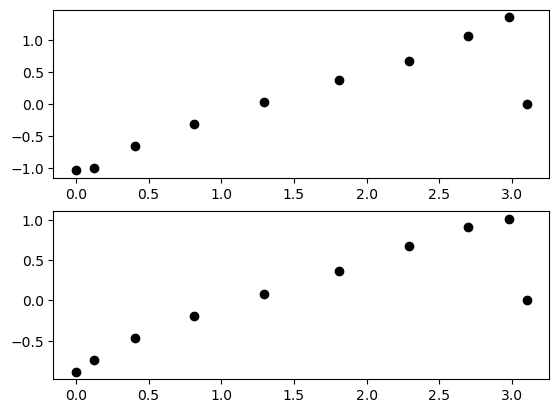

In [30]:
# Results of control input
fig, axs = plt.subplots(ndof, 1)
for i in range(Ntp):
    axs[0].plot(collo_pts[i], sol_us[i][0], color='black', marker='o')
    axs[1].plot(collo_pts[i], sol_us[i][1], color='black', marker='o')
plt.show()